In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import librosa as lb
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score 


In [3]:

#extracting features
def extract_features(file_path,feature_type='mfcc', max_pad_len=300):
    audio_data, sr = lb.load(file_path)

    if feature_type == 'mfcc':
        features = lb.feature.mfcc(y=audio_data, sr=sr)
    elif feature_type == 'mel':
        features = lb.feature.melspectrogram(y=audio_data,sr=sr)
    elif feature_type == 'chroma':
        features = lb.feature.chroma_stft(y=audio_data,sr=sr)
    elif feature_type == 'cqt':
        features = lb.feature.chroma_cqt(y=audio_data,sr=sr)

    # Pad or trim the features to a consistent length
    if features.shape[1] < max_pad_len:
        pad_width = max_pad_len - features.shape[1]
        features = np.pad(features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        features = features[:, :max_pad_len]
    
    return features

#For creating training data set
def create_training_data(folder_path,feature_type='mfcc'):
    X_train = []
    Y_train = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            features = extract_features(file_path,feature_type=feature_type)
            if('car_data_' in file_path.lower()):
                label = 0
            else:
                label = 1

            Y_train.append(label)
            X_train.append(features)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

    return X_train_normalized,Y_train



In [4]:
#creating test data set
def create_test_data(folder_path,feature_type):
    X_test = []
    Y_test = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            features = extract_features(file_path,feature_type=feature_type)
            if ('car_test_' in file_path.lower()):
                label = 0
            else:
                label = 1
            
            X_test.append(features)
            Y_test.append(label)
    

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    scaler = MinMaxScaler()
    X_test_normalized = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    
    return X_test_normalized,Y_test

In [5]:
#creating different training data sets to different features.
x_train_mfcc, y_train = create_training_data('train_data',feature_type='mfcc')
x_train_mel, y_train = create_training_data('train_data',feature_type='mel')
x_train_chroma, y_train = create_training_data('train_data',feature_type='chroma')
x_train_cqt,y_train = create_training_data('train_data',feature_type='cqt')

#Creating test data sets to different features
x_test_chroma, y_test = create_test_data('test_data',feature_type='chroma')
x_test_mfcc, y_test = create_test_data('test_data',feature_type='mfcc')
x_test_mel, y_test = create_test_data('test_data',feature_type='mel')
x_test_cqt, y_test = create_test_data('test_data', feature_type='cqt')



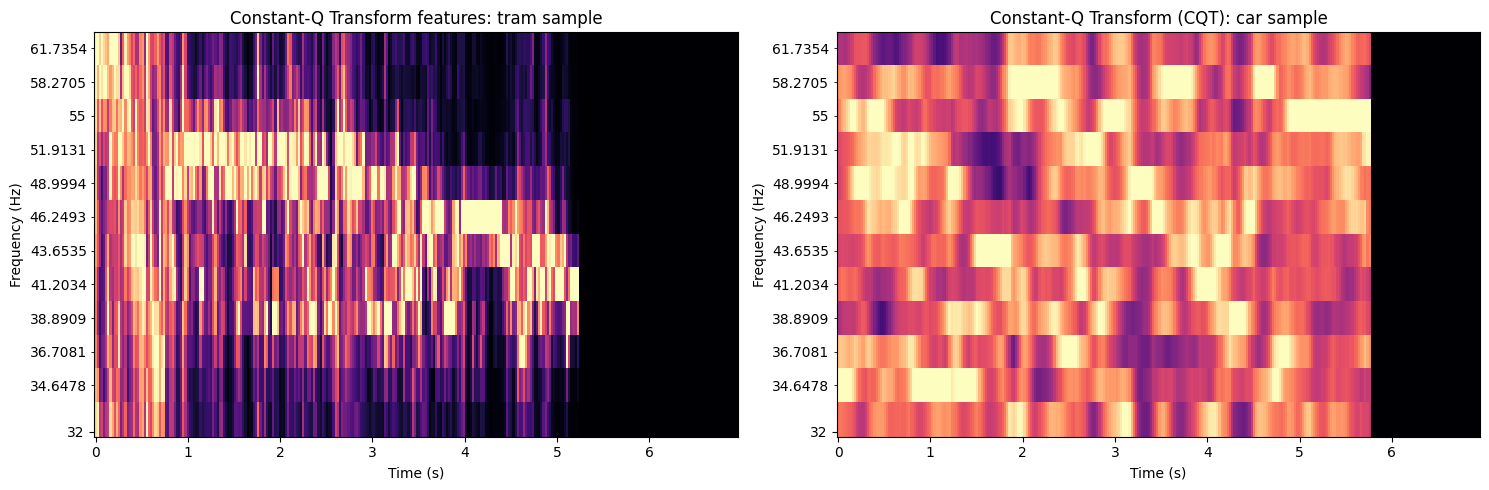

In [6]:
label_map = {0: 'car', 1:'tram'}
y_train_map = np.vectorize(label_map.get)(y_train)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

lb.display.specshow(x_train_chroma[25],y_axis='cqt_hz',x_axis='time')
plt.title(f'Constant-Q Transform features: {y_train_map[25]} sample')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1,2,2)
lb.display.specshow(x_train_cqt[20],y_axis='cqt_hz',x_axis='time')
plt.title(f'Constant-Q Transform (CQT): {y_train_map[20]} sample')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

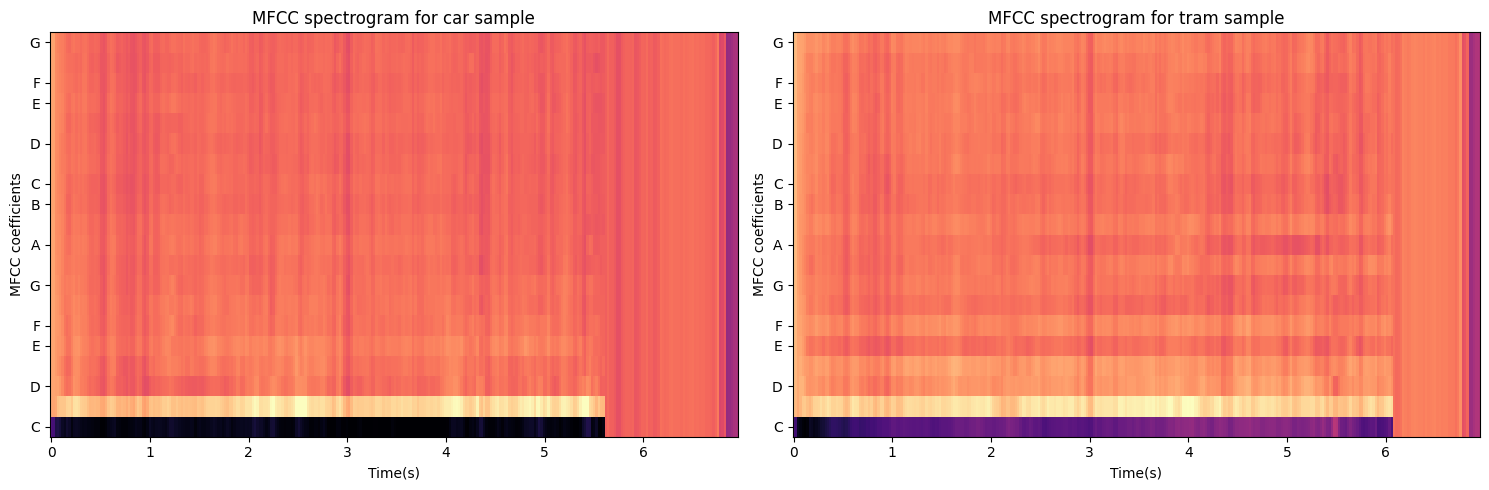

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

#mfcc for car
lb.display.specshow(x_train_mfcc[7],y_axis='chroma',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("MFCC coefficients")
plt.title("MFCC spectrogram for car sample")

plt.subplot(1,2,2)
# mel for tram
lb.display.specshow(x_train_mfcc[35],y_axis='chroma',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("MFCC coefficients")
plt.title("MFCC spectrogram for tram sample")

plt.tight_layout()
plt.show()

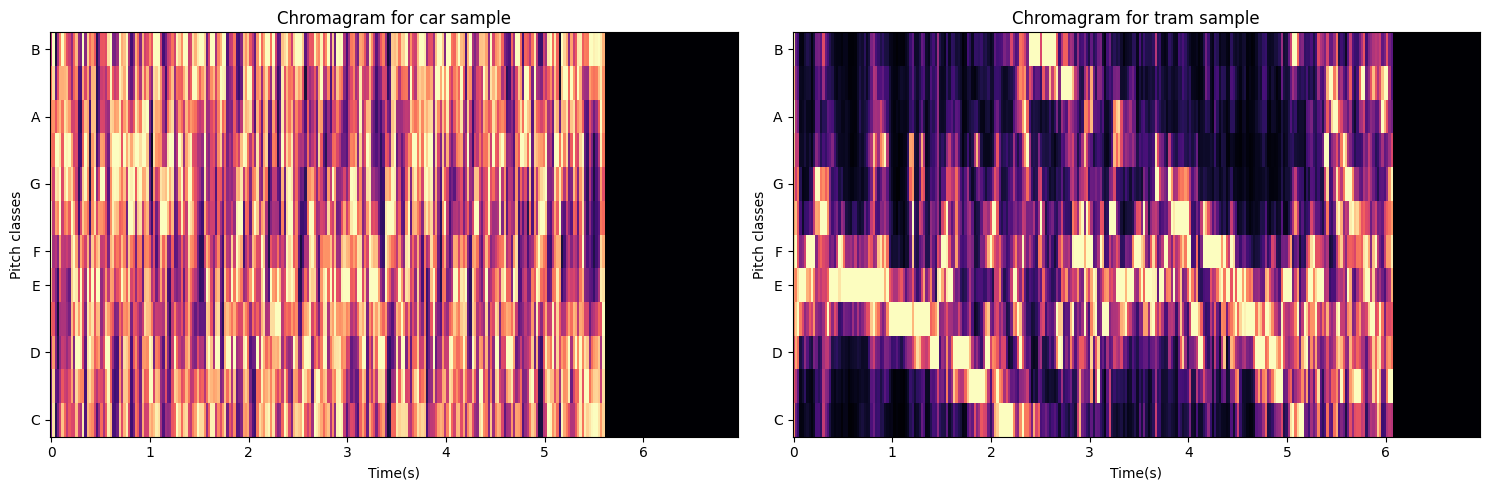

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

lb.display.specshow(x_train_chroma[7],y_axis='chroma',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("Pitch classes")
plt.title("Chromagram for car sample")

plt.subplot(1,2,2)
lb.display.specshow(x_train_chroma[35],y_axis='chroma',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("Pitch classes")
plt.title("Chromagram for tram sample")

plt.tight_layout()
plt.show()

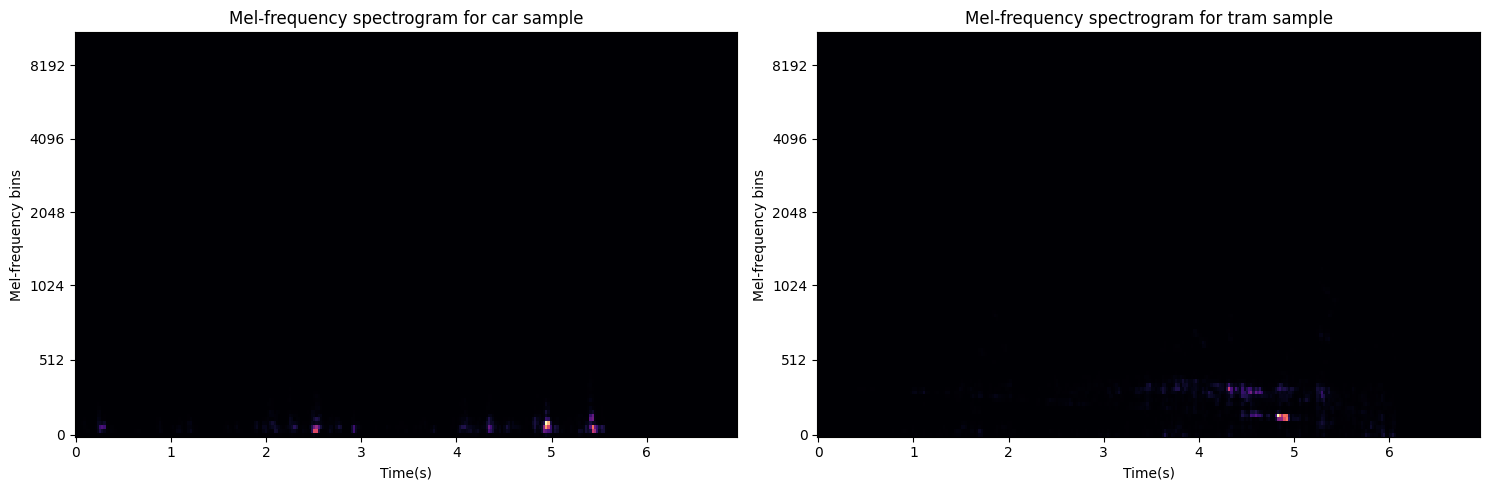

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

# mel for car
lb.display.specshow(x_train_mel[7],y_axis='mel',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("Mel-frequency bins")
plt.title("Mel-frequency spectrogram for car sample")

plt.subplot(1,2,2)
#mel for tram
lb.display.specshow(x_train_mel[35],y_axis='mel',x_axis='time')
plt.xlabel("Time(s)")
plt.ylabel("Mel-frequency bins")
plt.title("Mel-frequency spectrogram for tram sample")

plt.tight_layout()
plt.show()

In [10]:
#to calculate the euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Function to implement k-nearest neighbors algorithm
def k_nearest_neighbors(X_train, Y_train, new_data_point, k=4):
    distances = []

    for i, x_train in enumerate(X_train):
        distance = euclidean_distance(x_train, new_data_point)
        distances.append((Y_train[i], distance))

    distances.sort(key=lambda x: x[1])  # Sort distances in ascending order

    # Get the k nearest neighbors
    neighbors = distances[:k]

    # Count the votes for each class
    class_votes = {}
    for neighbor in neighbors:
        label = neighbor[0]
        class_votes[label] = class_votes.get(label, 0) + 1

    # Choose the class with the most votes
    predicted_class = max(class_votes, key=class_votes.get)

    return predicted_class


In [11]:

#creating predictions of classes
y_pred_mfcc = np.array([k_nearest_neighbors(x_train_mfcc,y_train,x) for x in x_test_mfcc])
y_pred_chroma = np.array([k_nearest_neighbors(x_train_chroma,y_train,x) for x in x_test_chroma])
y_pred_mel = np.array([k_nearest_neighbors(x_train_mel,y_train,x) for x in x_test_mel])
y_pred_cqt = np.array([k_nearest_neighbors(x_test_cqt,y_train,x) for x in x_test_cqt])

#Calculating the accuracy of classifications
accuracy_mfcc = accuracy_score(y_test,y_pred_mfcc)
accuracy_chroma = accuracy_score(y_test,y_pred_chroma)
accuracy_mel = accuracy_score(y_test,y_pred_mel)
accuracy_cqt = accuracy_score(y_test,y_pred_cqt)

print(f"mfcc: {accuracy_mfcc:.2f}")
print(f"chroma: {accuracy_chroma:.2f}")
print(f"mel: {accuracy_mel:.2f}")
print(f"Constant-Q: {accuracy_cqt:.2f}")


mfcc: 0.67
chroma: 1.00
mel: 0.56
Constant-Q: 0.44
